In [66]:
import pandas as pd
import geopandas as gpd
from rasterstats import zonal_stats
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Load PRISM data

In [181]:
df_prism = pd.read_csv('/Users/jingruj3/Desktop/ACE592/final project/PRISM.csv', skiprows=10, parse_dates=['Date'])
df_prism.head(5)

,Date,ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),tdmean (degrees F),vpdmin (hPa),vpdmax (hPa)
0,2009-01-01,0.00,-9.6,-0.4,8.8,-6.8,0.14,0.88
1,2009-01-02,0.00,2.6,12.2,21.8,11.3,0.18,1.06
2,2009-01-03,0.02,-1.0,6.7,14.4,-0.1,0.25,1.10
3,2009-01-04,0.14,13.4,20.4,27.4,20.4,0.06,1.09
4,2009-01-05,0.00,-8.2,9.2,26.7,1.9,0.12,1.02


Calculate Zonal Stats for Marathon County

In [18]:
county_shp = gpd.read_file('/Users/jingruj3/Desktop/ACE592/final project/MUNIBoundary.shp')


Create an animated graph for PRISM data with time as the variable:

In [33]:
monthly_mean['Date_str'] = monthly_mean['Date'].dt.strftime('%Y-%m')

fig = px.line(monthly_mean, x='Date', y='ppt (inches)', title='Mean Precipitation Over Time', 
              animation_frame='Date_str', range_y=[monthly_mean['ppt (inches)'].min(), monthly_mean['ppt (inches)'].max()])
fig.show()

monthly_mean = monthly_mean.drop(columns=['Date_str'])

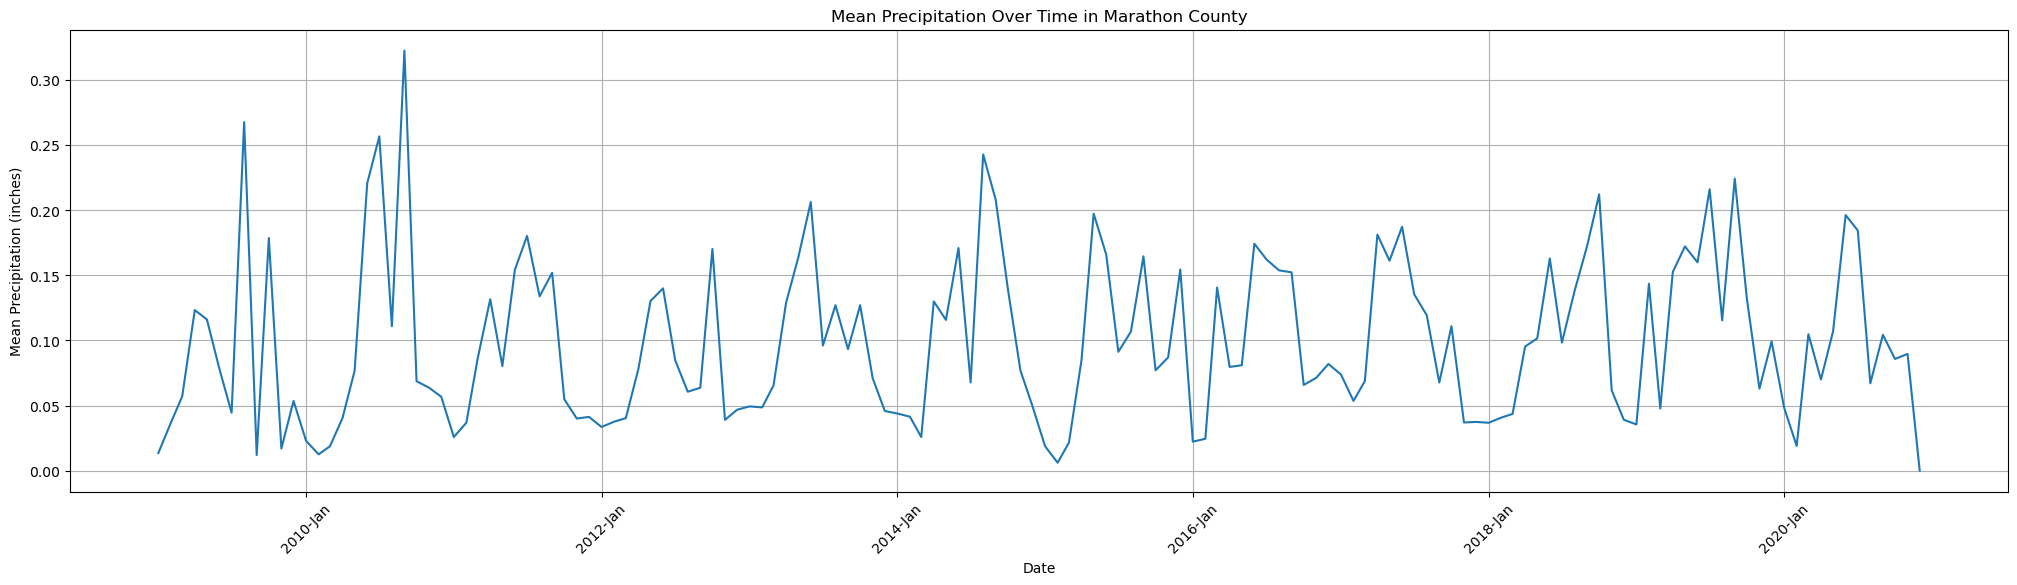

In [69]:
# Plot mean precipitation over time
monthly_mean = df_prism.groupby(df_prism['Date'].dt.to_period('M')).mean().reset_index()
monthly_mean['Date'] = monthly_mean['Date'].dt.to_timestamp()


plt.figure(figsize=(25, 6))
plt.plot(monthly_mean['Date'], monthly_mean['ppt (inches)'])
plt.xlabel('Date')
plt.ylabel('Mean Precipitation (inches)')
plt.title('Mean Precipitation Over Time in Marathon County')

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

plt.xticks(rotation=45)
plt.grid()
plt.show()

Create a list of rainfall spike events in marathon county/correlate with P reading spikes:

In [36]:
#read the water quality data from the Excel file and filter the data to only include phosphorus samples.
df_wq = pd.read_excel('/Users/jingruj3/Desktop/ACE592/final project/Marathon_WQ_Only.xlsx')
df_wq = df_wq[df_wq['phosphorus_sample'] == 1]
df_wq.head()

,organizationidentifier,organizationformalname,monitoringlocationidentifier,monitoringlocationname,monitoringlocationtypename,monitoringlocationdescriptiontex,huceightdigitcode,drainageareameasuremeasurevalue,drainageareameasuremeasureunitco,contributingdrainageareameasurem,...,date,detection_type,resultvalue,detection_limit,unclear_result,bdl,nitrogen_sample,phosphorus_sample,ammonia_sample,fipscode
2,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10008431,Comet Creek Sth 153 Site 2,River/Stream,NaN,4030202,NaN,NaN,NaN,...,20676,NaN,0.0423,NaN,0,0,0,1,0,55073
4,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10009487,ARTUS CREEK 25 M UPSTREAM 136 AVE.,River/Stream,NaN,7070002,NaN,NaN,NaN,...,19127,NaN,0.0270,NaN,0,0,0,1,0,55073
5,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10009493,SODA CREEK 11 METERS UPSTREAM SODA CREEK ROAD,River/Stream,NaN,7070002,NaN,NaN,NaN,...,20361,NaN,0.0615,NaN,0,0,0,1,0,55073
6,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10009495,Unnamed Creek 10-2 - 35 M Upstream Soda Creek ...,River/Stream,NaN,7070002,NaN,NaN,NaN,...,20361,NaN,0.0336,NaN,0,0,0,1,0,55073
7,WIDNR_WQX,Wisconsin Department of Natural Resources,WIDNR_WQX-10009496,Pet Brook Creek - 15 M Elderberry,River/Stream,NaN,7070002,NaN,NaN,NaN,...,20362,NaN,0.0865,NaN,0,0,0,1,0,55073


In [176]:
#find the rainfall spike events in the PRISM data 
#join the water quality data with the PRISM data based on the date
threshold_rainfall_spike = 1.0  # Set an appropriate threshold
spike_events = df_prism[df_prism['ppt (inches)'] > threshold_rainfall_spike]

df_combined = pd.merge(spike_events, df_wq, left_on='Date', right_on='analysisstartdate')

# Read the watershed and county boundary shapefiles
watersheds_shp = gpd.read_file('/Users/jingruj3/Desktop/ACE592/final project/Marathon_Watershed_HUC10.shp')
county_shp = gpd.read_file('/Users/jingruj3/Desktop/ACE592/final project/MUNIBoundary.shp')



In [77]:
# Check the CRS of both shapefiles
print("Watersheds CRS:", watersheds_shp.crs)
print("County CRS:", county_shp.crs)

# Reproject the watersheds shapefile to match the county CRS if they are different
if watersheds_shp.crs != county_shp.crs:
    watersheds_shp = watersheds_shp.to_crs(county_shp.crs)
    print("Watersheds CRS has been reprojected to match the County CRS")

# Clip the watersheds to the county boundary
county_boundary = county_shp.geometry.unary_union
clipped_watersheds = watersheds_shp[watersheds_shp.geometry.intersects(county_boundary)]


Watersheds CRS: PROJCS["User_Defined_Lambert_Conformal_Conic",GEOGCS["GCS_User_Defined",DATUM["D_User_Defined",SPHEROID["User_Defined_Spheroid",6378500.6,298.274224921893]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",44.4055555555556],PARAMETER["central_meridian",-89.77],PARAMETER["standard_parallel_1",44.7452777777778],PARAMETER["standard_parallel_2",45.0563888888889],PARAMETER["false_easting",244999.999992458],PARAMETER["false_northing",0],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
County CRS: PROJCS["User_Defined_Lambert_Conformal_Conic",GEOGCS["GCS_User_Defined",DATUM["D_User_Defined",SPHEROID["User_Defined_Spheroid",6378500.6,298.274224921893]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",44.4055555555556],PARAMETER["central_meridian",-89.77],PAR

,OBJECTID,WSHED_NAME,PWS_STATUS,NPS_PRIORI,WSHED_CODE,WATERSHED_,WATERSHE_1,TOTAL_STRE,TOTAL_LAKE,TOTAL_WETL,NPS_OVERAL,NPS_OVER_1,NPS_STREAM,NPS_STRE_1,NPS_LAKE_R,NPS_LAKE_1,NPS_GW_RAN,NPS_GW_R_1,geometry
0,393,Upper Eau Claire River,None,0,CW22,141671.72,221.36,0.00,0.00,40234.77,High,The watershed is ranked for overall nonpoint s...,High,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"POLYGON ((372693.116 235110.199, 372154.693 23..."
1,397,Upper Rib River,None,0,CW26,126122.31,197.07,0.00,0.00,17127.41,Low,The watershed is ranked for overall nonpoint s...,Low,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,Low,The watershed is ranked for groundwater nonpoi...,"POLYGON ((199640.072 225264.855, 199570.145 22..."
2,409,Copper River,None,0,UW31,65949.36,103.05,187.03,64.93,15346.42,Low,The watershed is ranked for overall nonpoint s...,NR,Not Ranked,Low,The watershed is ranked for lakes nonpoint sou...,Low,The watershed is ranked for groundwater nonpoi...,"POLYGON ((208361.981 258589.226, 208283.698 25..."
3,410,Trappe River,None,0,CW27,64093.40,100.15,0.00,0.00,8389.83,Med,The watershed is ranked for overall nonpoint s...,Low,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,Med,The watershed is ranked for groundwater nonpoi...,"POLYGON ((282447.620 228779.910, 282325.426 22..."
4,413,Devil Creek,None,0,CW28,43837.53,68.50,0.00,0.00,2336.54,High,The watershed is ranked for overall nonpoint s...,Med,The watershed is ranked for streams nonpoint s...,Low,The watershed is ranked for lakes nonpoint sou...,High,The watershed is ranked for groundwater nonpoi...,"MULTIPOLYGON (((273038.637 229102.107, 272940...."


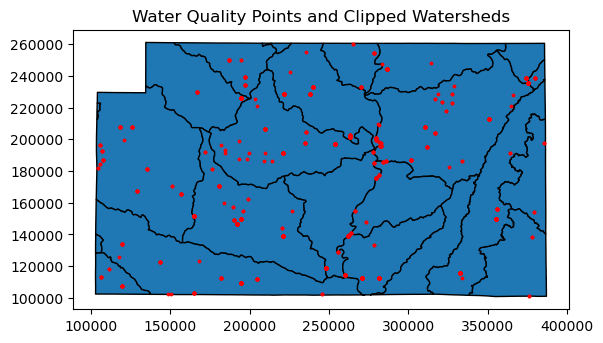

In [160]:
# Read the water quality data and convert it to a GeoDataFrame
df_combined = pd.read_excel('/Users/jingruj3/Desktop/ACE592/final project/Marathon_WQ_Only.xlsx')
gdf_combined = gpd.GeoDataFrame(df_combined, geometry=gpd.points_from_xy(df_combined['longitudemeasure'], df_combined['latitudemeasure']))
gdf_combined.crs = clipped_watersheds.crs

# Set the CRS for the water quality points
gdf_combined.crs = "EPSG:4326"  # Replace "EPSG:4326" with the correct CRS for the water quality points

# Reproject the water quality points to the same CRS as the clipped watersheds
gdf_combined = gdf_combined.to_crs(clipped_watersheds.crs)

fig, ax = plt.subplots()
clipped_watersheds.plot(ax=ax, edgecolor="black", linewidth=1)
gdf_combined.plot(ax=ax, color="red", markersize=3)
plt.title("Water Quality Points and Clipped Watersheds")
plt.show()


/Users/jingruj3/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



<AxesSubplot:>

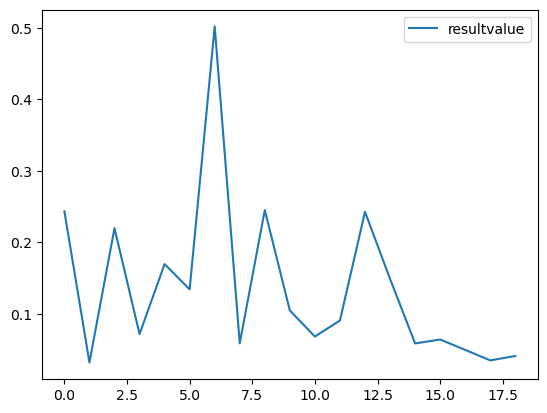

In [113]:
# Perform a spatial join between the water quality data and the clipped watersheds
gdf_spatial_join = gpd.sjoin(gdf_combined, clipped_watersheds, op='within')

# Group the spatially joined data by watersheds using 'WSHED_CODE' and calculate the mean phosphorus level for each group
watershed_phosphorus_mean = gdf_spatial_join.groupby('WSHED_CODE')['resultvalue'].mean().reset_index()


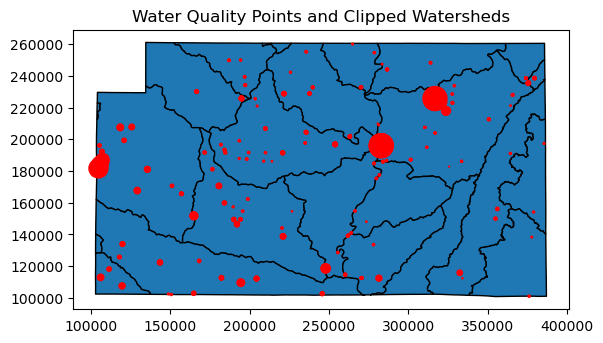

In [131]:
fig, ax = plt.subplots()
clipped_watersheds.plot(ax=ax, edgecolor="black", linewidth=1)

# Normalize the resultmeasurevalue column for better visualization
normalized_measurements = (gdf_combined['resultvalue'] - gdf_combined['resultvalue'].min()) / (gdf_combined['resultvalue'].max() - gdf_combined['resultvalue'].min())

# Multiply the normalized measurements by a scaling factor to control the marker size
scaling_factor = 300
marker_size = normalized_measurements * scaling_factor

gdf_combined.plot(ax=ax, color="red", markersize=marker_size)
plt.title("Water Quality Points and Clipped Watersheds")
plt.show()


In [161]:
# Convert the PRISM date column to datetime format
df_prism['Date'] = pd.to_datetime(df_prism['Date'])

# Convert the gdf_combined date column from the integer format to datetime
gdf_combined['date'] = pd.to_datetime(gdf_combined['date'], unit='D', origin='1960-01-01')


In [163]:
# Merge the datasets on the date column
merged_data = gdf_combined.merge(df_prism, left_on='date', right_on='Date')

In [164]:
correlation = merged_data['ppt (inches)'].corr(merged_data['resultvalue'])
print("Correlation between precipitation and water quality:", correlation)

Correlation between precipitation and water quality: 0.03554465703222387


In [167]:
# Merge gdf_combined with PRISM data
gdf_merged = gdf_combined.merge(df_prism, left_on='date', right_on='Date', how='left')

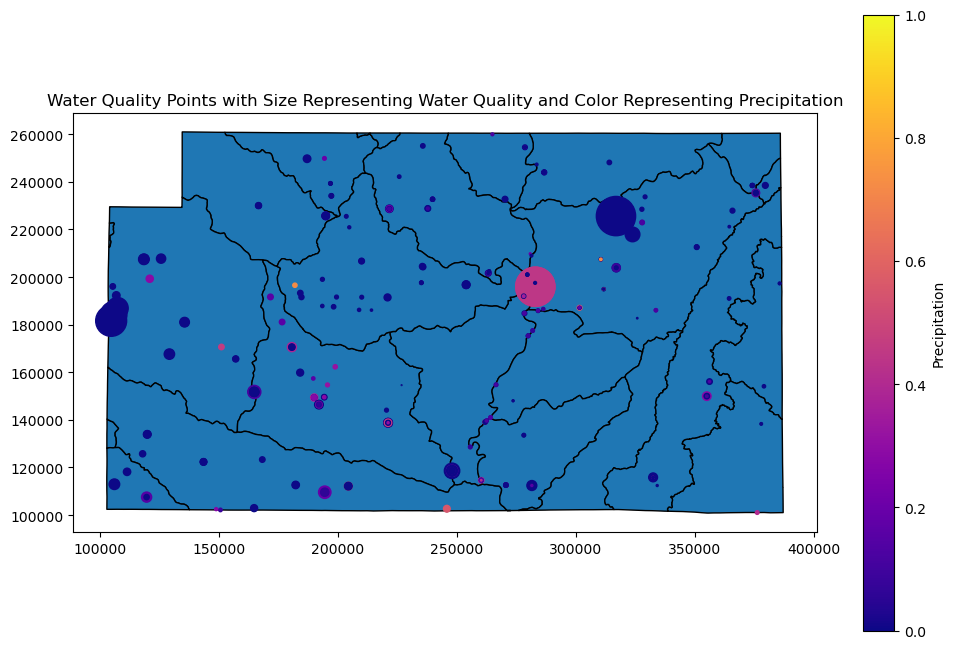

In [194]:
def normalize_power(series, power=0.5):
    return np.power((series - series.min()) / (series.max() - series.min()), power)

# Apply the new normalization function to the 'ppt (inches)' column in the merged GeoDataFrame.
gdf_merged['normalized_ppt'] = normalize_power(gdf_merged['ppt (inches)'], 0.5)

fig, ax = plt.subplots(figsize=(12, 8))
clipped_watersheds.plot(ax=ax, edgecolor="black", linewidth=1)

# Set marker size and color based on normalized water quality result values and precipitation data
marker_size = gdf_merged['normalized_resultvalue'] * 800
marker_color = gdf_merged['normalized_ppt']

gdf_merged.plot(ax=ax, markersize=marker_size, column=marker_color, legend=True, cmap='plasma', 
                legend_kwds={'label': "Precipitation", 'orientation': "vertical"})

plt.title("Water Quality Points with Size Representing Water Quality and Color Representing Precipitation")
plt.show()


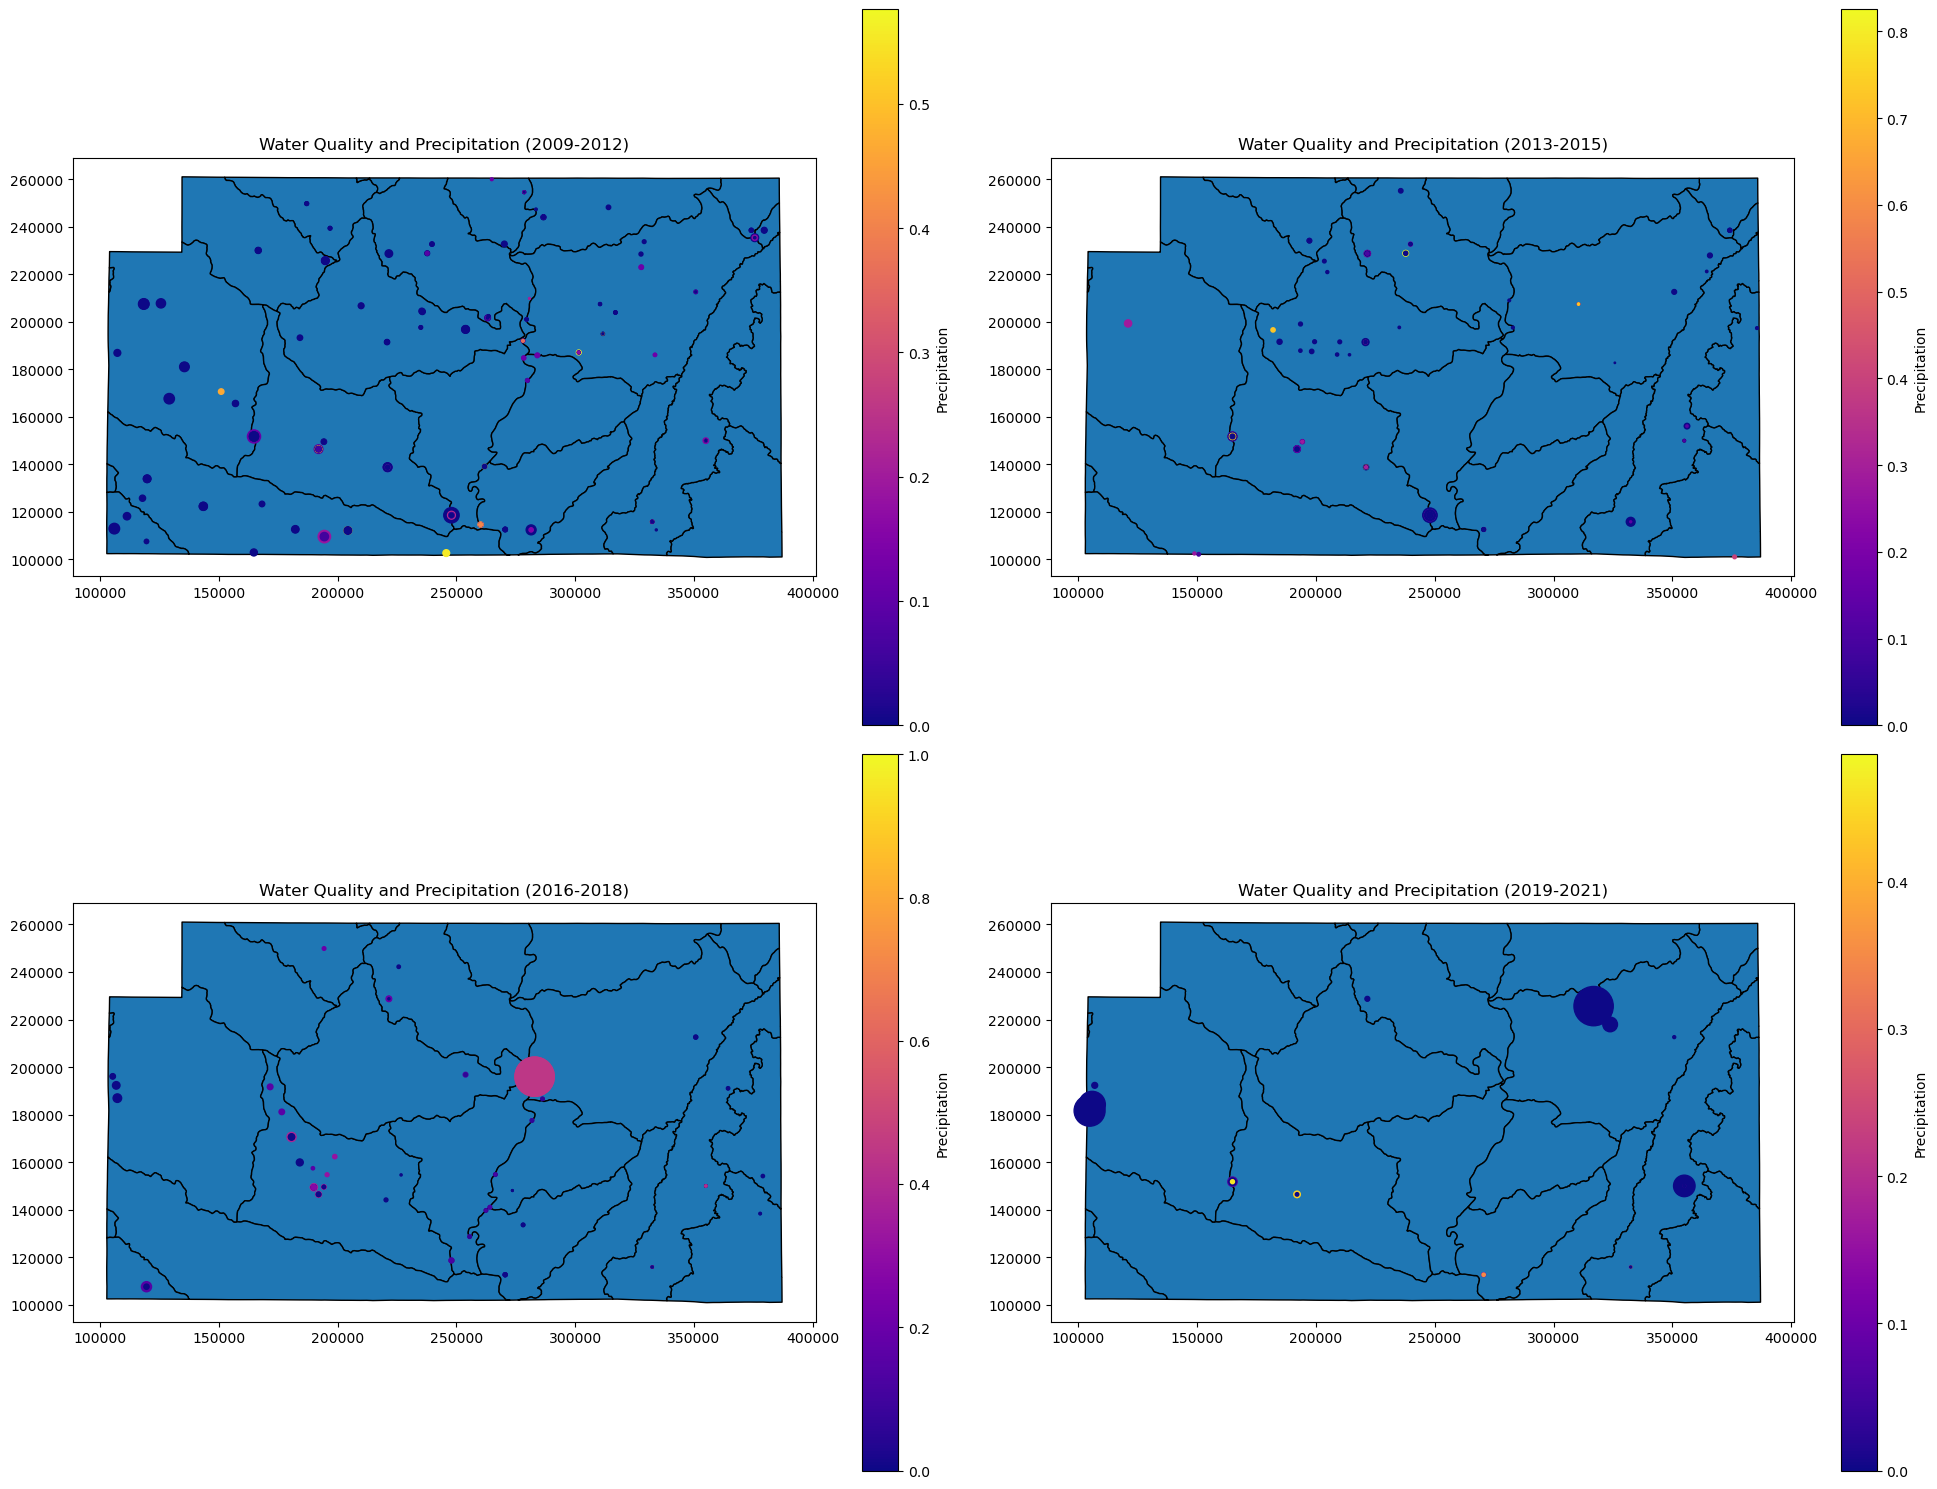

In [195]:
# Define year ranges
year_ranges = [(2009, 2012), (2013, 2015), (2016, 2018), (2019, 2021)]

# Set up the 2x2 subplot matrix
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, (start_year, end_year) in enumerate(year_ranges):
    ax = axes[i]
    
    # Filter the merged GeoDataFrame based on the year range
    gdf_filtered = gdf_merged[(gdf_merged['year'] >= start_year) & (gdf_merged['year'] <= end_year)]
    
    clipped_watersheds.plot(ax=ax, edgecolor="black", linewidth=1)
    
    # Set marker size and color based on normalized water quality result values and precipitation data
    marker_size = gdf_filtered['normalized_resultvalue'] * 800
    marker_color = gdf_filtered['normalized_ppt']
    
    gdf_filtered.plot(ax=ax, markersize=marker_size, column=marker_color, legend=True, cmap='plasma', 
                      legend_kwds={'label': "Precipitation", 'orientation': "vertical"})
    
    ax.set_title(f"Water Quality and Precipitation ({start_year}-{end_year})")

plt.tight_layout()
plt.show()


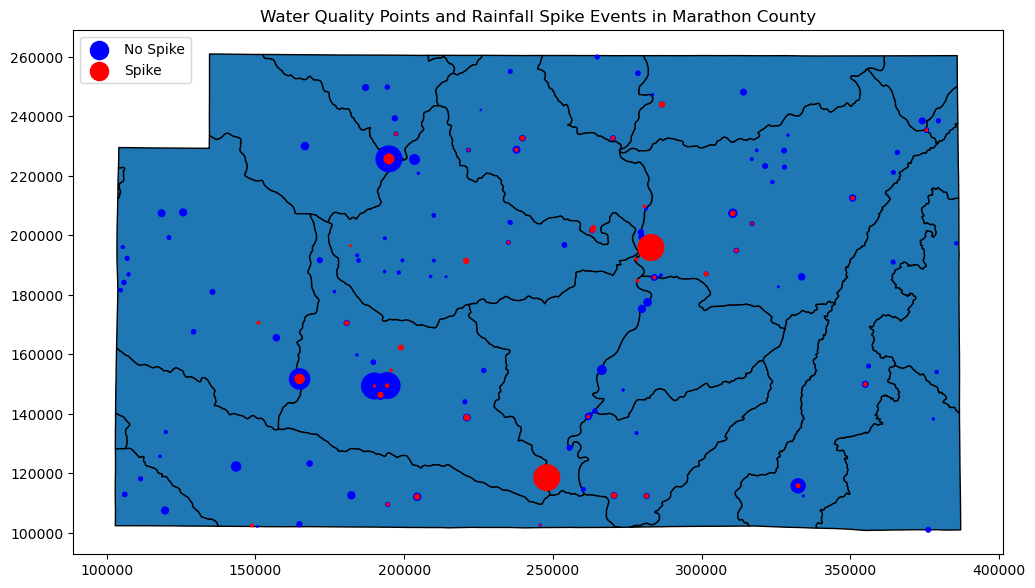

In [191]:
# Calculate the rolling mean precipitation with a 7-day window
df_prism['rolling_mean_precip'] = df_prism['ppt (inches)'].rolling(window=7, center=True, min_periods=1).mean()

# Define a spike threshold, for example, twice the rolling mean precipitation
df_prism['spike_threshold'] = df_prism['rolling_mean_precip'] * 2

# Create a binary column to indicate whether a rainfall spike event occurred
df_prism['rainfall_spike'] = (df_prism['ppt (inches)'] > df_prism['spike_threshold']).astype(int)

# Merge PRISM and gdf_combined datasets on the date column
gdf_combined_with_spike = gdf_combined.merge(df_prism[['Date', 'rainfall_spike']], left_on='date', right_on='Date', how='left')

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the clipped watersheds
clipped_watersheds.plot(ax=ax, edgecolor="black", linewidth=1)

# Plot water quality points for non-spike days
gdf_combined_with_spike[gdf_combined_with_spike['rainfall_spike'] == 0].plot(
    ax=ax, markersize=gdf_combined_with_spike['resultvalue'] * 40, color='blue', label='No Spike', legend=True)

# Plot water quality points for spike days
gdf_combined_with_spike[gdf_combined_with_spike['rainfall_spike'] == 1].plot(
    ax=ax, markersize=gdf_combined_with_spike['resultvalue'] * 40, color='red', label='Spike', legend=True)

ax.legend(loc='upper left')
plt.title("Water Quality Points and Rainfall Spike Events in Marathon County")
plt.show()

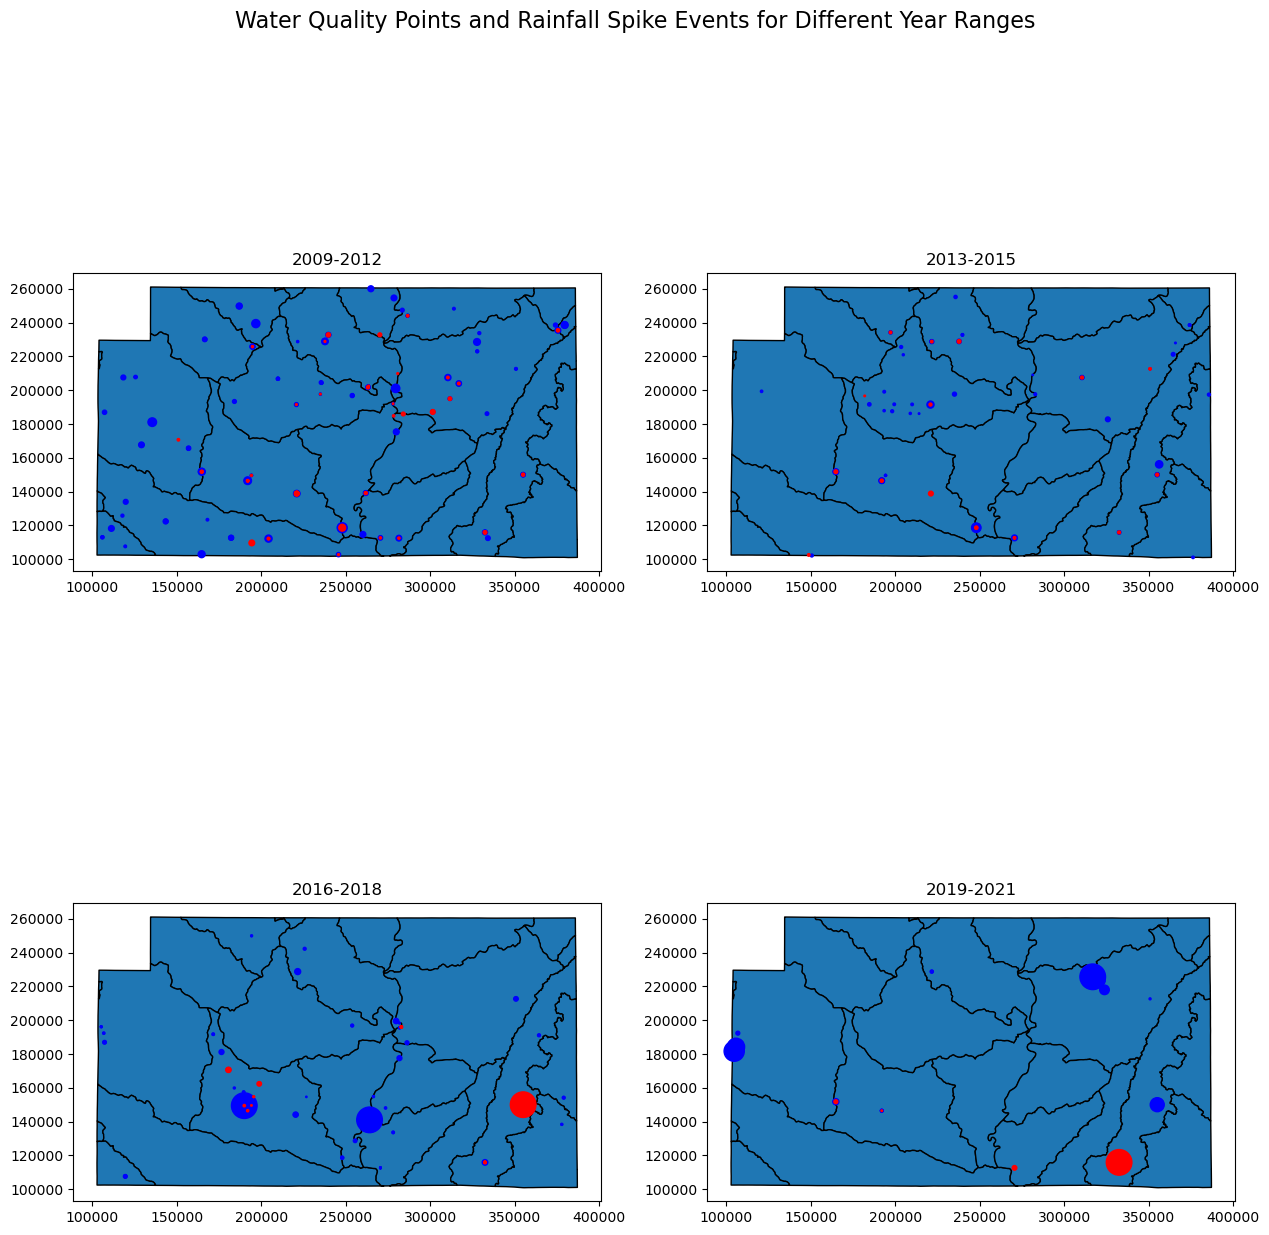

In [196]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

year_ranges = [
    ('2009-01-01', '2012-12-31', 0, 0),
    ('2013-01-01', '2015-12-31', 0, 1),
    ('2016-01-01', '2018-12-31', 1, 0),
    ('2019-01-01', '2021-12-31', 1, 1)
]

for start_date, end_date, row, col in year_ranges:
    # Filter the data by year range
    gdf_filtered = gdf_combined_with_spike[(gdf_combined_with_spike['date'] >= start_date) & (gdf_combined_with_spike['date'] <= end_date)]
    
    # Plot the clipped watersheds
    clipped_watersheds.plot(ax=axs[row, col], edgecolor="black", linewidth=1)
    
    # Plot water quality points for non-spike days
    gdf_filtered[gdf_filtered['rainfall_spike'] == 0].plot(ax=axs[row, col], markersize=gdf_filtered['resultvalue'] * 40, color='blue', label='No Spike')
    
    # Plot water quality points for spike days
    gdf_filtered[gdf_filtered['rainfall_spike'] == 1].plot(ax=axs[row, col], markersize=gdf_filtered['resultvalue'] * 40, color='red', label='Spike')

    axs[row, col].set_title(f'{start_date[:4]}-{end_date[:4]}')

# Add a title for the entire figure
fig.suptitle('Water Quality Points and Rainfall Spike Events for Different Year Ranges', fontsize=16)
plt.show()


In [197]:
import scipy.stats as stats

# Filter the data to remove rows with missing values
gdf_filtered = gdf_combined_with_spike.dropna(subset=['rainfall_spike', 'resultvalue'])

# Calculate the correlation using Spearman's rank correlation
correlation, p_value = stats.spearmanr(gdf_filtered['rainfall_spike'], gdf_filtered['resultvalue'])

print("Spearman's rank correlation coefficient:", correlation)
print("p-value:", p_value)


Spearman's rank correlation coefficient: -0.005014077263310419
p-value: 0.8535388413274623
